In [3]:
import numpy as np
import pandas as pd
import struct
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('darkgrid')
import sys
import os
import seaborn
from  matplotlib import pyplot

In [4]:
import io

# functions for reading files
        
def read_data(start, end, paths, data_name):
    data = []
    for path in paths:
        for i in range(start, end + 1):
            data_path = f'{path[0]}/{data_name}_{i:04}'
            if(os.path.isfile(data_path)):
                data.append(pd.read_csv(data_path, header = 0, names=['cluster size', 'number']))
                data[-1]['conf'] = i
                data[-1]['time size'] = path[1]
    
    return pd.concat(data)

In [5]:
# save image
def save_image_time(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    
    output_path = f'{image_path}/{image_name}'
    fg.savefig(output_path, dpi=400)

In [19]:
# functions for density of wrapped and unwrapped clusters

def data_process_density(data):
    return data.groupby(['cluster size', 'time size'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()

def fill_zeroes(data):
    return data.set_index(['conf', 'cluster size']).unstack('cluster size', fill_value=0).stack()

def make_bins(data):
    print(data)
    bin_size = (data.name.left + data.name.right) / 2
    return data.sum()/bin_size

def data_process_upper(data, bin_num):
    return data.groupby([pd.cut(data['cluster size'], bin_num)])['number']\
        .apply(make_bins).reset_index()\
        .groupby(['cluster size'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))])

def density(start, end, paths, bin_num, file_name):
    data = read_data(start, end, paths, file_name)

    data = data.groupby(['time size'])[['cluster size', 'number', 'conf']].apply(fill_zeroes).reset_index()

    # print(data)

    # data = data.groupby(['cluster size', 'time size', 'conf'])['number']\
    #     .agg([('number', np.mean)]).reset_index()\
    #     .groupby(['time size'])\
    #     .apply(data_process_upper, bin_num).reset_index()

    # data['cluster size'] = data['cluster size'].apply(lambda x: (x.right + x.left) / 2)

    data = data_process_density(data)

    data = data[(data['cluster size'] <= 50) & (data['cluster size'] >= 1)]
    # data = data[data['cluster size'] <= 500]

    print(data)

    fg = seaborn.FacetGrid(data=data, hue = 'time size', height=5, aspect=1.61)
    fg.fig.suptitle(f'cluster density')
    plt.yscale('log')
    plt.xscale('log')
    fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()

    # print(data)

def maximal_cluster(start, end, paths):
    data = []
    data.append(read_data(start, end, paths, 'unwrapped'))
    data.append(read_data(start, end, paths, 'wrapped'))

    data = pd.concat(data)
    
def max_clusters(start, end, paths, file_name):
    data = read_data(start, end, paths, file_name)

    data = data.groupby(['conf'])[['cluster size']].agg([('max cluster', max)]).reset_index()
    print(data)

    cluster size      time size       number       std
0              4  T_step=0.0001  2628.937500  8.356709
1              4  T_step=0.0005  2635.479167  8.832312
2              4   T_step=0.001  2622.187500  8.414445
3              6  T_step=0.0001   900.208333  4.312994
4              6  T_step=0.0005   892.791667  4.359301
..           ...            ...          ...       ...
67            48  T_step=0.0005     0.375000  0.087443
68            48   T_step=0.001     0.520833  0.098704
69            50  T_step=0.0001     0.375000  0.105794
70            50  T_step=0.0005     0.291667  0.078541
71            50   T_step=0.001     0.458333  0.115156

[72 rows x 4 columns]


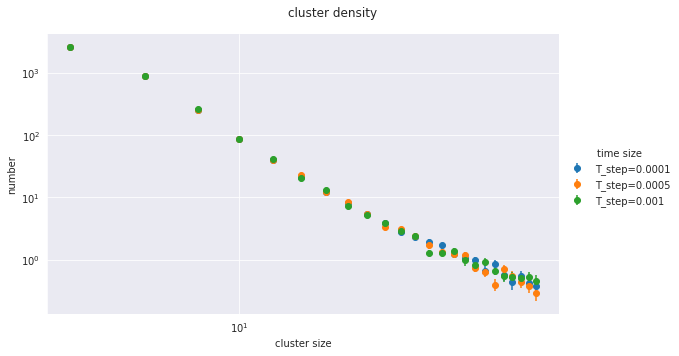

In [20]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.0001'), 
        (f'{path}/T_step=0.0005/T_final=0.0005/OR_steps=4/clusters_unwrapped', 'T_step=0.0005'),
        (f'{path}/T_step=0.001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.001')]

density(1, 50, paths, 10, 'clusters_unwrapped')

In [6]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.0001')]

max_clusters(1, 50, paths, 'clusters_unwrapped')

   conf cluster size
         max cluster
0     1         5964
1     2          284
2     3         5872
3     4         2468
4     5         2656
5     6         2200
6     7         6720
7     8          922
8     9         7090
9    10         3366
10   11         2046
11   12         2458
12   14          452
13   15         1986
14   16         5192
15   17         8606
16   18         5922
17   19         4582
18   20         4658
19   21          530
20   22         3054
21   23         4446
22   24          466
23   25         5568
24   26         8886
25   27         3070
26   28         3508
27   29          860
28   30         6148
29   31          170
30   32         4632
31   33         5340
32   34         8964
33   35         1458
34   36          728
35   37         1478
36   38         5010
37   39          886
38   40          116
39   41          412
40   42         3430
41   43         4092
42   44         2276
43   45         9356
44   46         1424
45   48      

In [7]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_wrapped', 'T_step=0.0001')]

data = read_data(1, 50, paths, 'clusters_wrapped').reset_index(drop=True)
print(data)

   cluster size number  conf      time size
0          1032      1     2  T_step=0.0001
1          3480      1     2  T_step=0.0001
2           828      1     4  T_step=0.0001
3          3582      1     4  T_step=0.0001
4           294      1     5  T_step=0.0001
..          ...    ...   ...            ...
58         3578      1    48  T_step=0.0001
59         1324      1    49  T_step=0.0001
60         3724      1    49  T_step=0.0001
61         2770      1    50  T_step=0.0001
62         6300      1    50  T_step=0.0001

[63 rows x 4 columns]


In [8]:
def get_large_wrapped(data, threshold):
    if data.shape[0] >= 2:
        data = data.sort_values(by=['cluster size'])
        if (data['cluster size'].iloc[-1] > threshold) or (data['cluster size'].iloc[-2] > threshold):
            return data.iloc[-2:]


def clusters_divide(data_unwrapped, data_wrapped, size_threshold):
    data_large_unwrapped = data_unwrapped[data_unwrapped['cluster size'] > size_threshold]

    data_small_unwrapped = data_unwrapped[data_unwrapped['cluster size'] <= size_threshold]

    data_large_wrapped = data_wrapped.groupby(['conf']).apply(get_large_wrapped, size_threshold).reset_index(drop=True)


    data_large = pd.concat([data_large_unwrapped, data_large_wrapped])
    print(data_large)
    data_large = data_large.groupby(['conf', 'time size'])[['cluster size']].apply(sum).reset_index()
    print(data_large)

In [13]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths_unwrapped = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.0001')]
paths_wrapped = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_wrapped', 'T_step=0.0001')]

data_unwrapped = read_data(1, 50, paths_unwrapped, 'clusters_unwrapped').reset_index(drop=True)
data_wrapped = read_data(1, 50, paths_wrapped, 'clusters_wrapped').reset_index(drop=True)

data_wrapped_test = data_wrapped[data_wrapped['cluster size'] > 1000]
print(data_wrapped_test)

# print(data_unwrapped)
# print(data_wrapped)
size_threshold = 800

# clusters_divide(data_unwrapped, data_wrapped, size_threshold)

   cluster size number  conf      time size
0          1032      1     2  T_step=0.0001
1          3480      1     2  T_step=0.0001
3          3582      1     4  T_step=0.0001
6          3536      1     5  T_step=0.0001
7          1586      1     8  T_step=0.0001
8          3580      1     8  T_step=0.0001
10         5084      1    10  T_step=0.0001
12         1034      1    12  T_step=0.0001
13         1164      1    14  T_step=0.0001
14         5016      1    14  T_step=0.0001
15         3068      1    15  T_step=0.0001
16         4702      1    15  T_step=0.0001
17         1224      1    21  T_step=0.0001
18         5600      1    21  T_step=0.0001
19         4740      1    24  T_step=0.0001
20         5952      1    24  T_step=0.0001
21         1580      1    25  T_step=0.0001
22         2086      1    25  T_step=0.0001
23         1532      1    27  T_step=0.0001
24         1714      1    27  T_step=0.0001
25         3220      1    28  T_step=0.0001
26         3386      1    28  T_

In [10]:
def cluster_gap_unwrapped(data, threshold_max):
    
    for threshold in range(threshold_max):
        data1 = data[data['cluster size'] <= threshold]
        